In [285]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [286]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 9912422/9912422 [00:01<00:00, 6908425.22it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6830703.38it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5028978.45it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14410384.85it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw


In [287]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(
        train_data,
        batch_size=100,
        shuffle=True,
        num_workers=1),

    'test_loader': DataLoader(
        test_data,
        batch_size=100,
        shuffle=True,
        num_workers=1),
}

In [288]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        return F.softmax(x)

In [289]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()


def train(e):  #epoch
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                f'Train epoch {e} [{batch_idx * len(data)}/{len(loaders["train"].dataset)}  ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')


def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(
        f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')

In [290]:
for epoch in range(1, 11):
    train(epoch)

/var/folders/cn/pbbb97x54y9cd1y670hyldq00000gn/T/ipykernel_48796/114032758.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train epoch 1 [0/60000  (0%)]	3.911411
Train epoch 1 [2000/60000  (3%)]	3.814650
Train epoch 1 [4000/60000  (7%)]	3.741551
Train epoch 1 [6000/60000  (10%)]	3.652132
Train epoch 1 [8000/60000  (13%)]	3.710813
Train epoch 1 [10000/60000  (17%)]	3.589747
Train epoch 1 [12000/60000  (20%)]	3.576722
Train epoch 1 [14000/60000  (23%)]	3.538200
Train epoch 1 [16000/60000  (27%)]	3.543557
Train epoch 1 [18000/60000  (30%)]	3.514244
Train epoch 1 [20000/60000  (33%)]	3.553155
Train epoch 1 [22000/60000  (37%)]	3.551398
Train epoch 1 [24000/60000  (40%)]	3.594995
Train epoch 1 [26000/60000  (43%)]	3.510008
Train epoch 1 [28000/60000  (47%)]	3.532353
Train epoch 1 [30000/60000  (50%)]	3.583658
Train epoch 1 [32000/60000  (53%)]	3.498607
Train epoch 1 [34000/60000  (57%)]	3.548115
Train epoch 1 [36000/60000  (60%)]	3.500253
Train epoch 1 [38000/60000  (63%)]	3.466285
Train epoch 1 [40000/60000  (67%)]	3.459991
Train epoch 1 [42000/60000  (70%)]	3.499145
Train epoch 1 [44000/60000  (73%)]	3.505238

Prediction: 6


/var/folders/cn/pbbb97x54y9cd1y670hyldq00000gn/T/ipykernel_48796/114032758.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


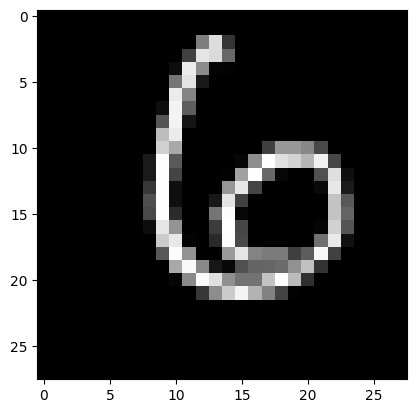

In [299]:
import matplotlib.pyplot as plt

model.eval()
data, target = test_data[100]             

# change * in test_data[*] on any numer in range 0 - 999
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='grey')
plt.show()